# Pairs generation

In [ ]:
# a=0
b=0
queries = []
answers = []
while a<100:
    b=0
    while b<100:
        queries.append(str(a)+"+"+str(b)) #a + b is always > 0 if a and b are >0
        answers.append("+"+str(a+b))
        queries.append(str(a)+"-"+str(b)) #a + b is always > 0 if a and b are >0
        if a-b>=0:
            answers.append("+"+str(a-b))
        else:
            answers.append(str(a-b)) #the minus sign is here by default
        b+=1 
    a+=1

In [2]:
print(len(queries),len(answers))

20000 20000


In [3]:
list(zip(queries, answers))[:10]

[('0+0', '+0'),
 ('0-0', '+0'),
 ('0+1', '+1'),
 ('0-1', '-1'),
 ('0+2', '+2'),
 ('0-2', '-2'),
 ('0+3', '+3'),
 ('0-3', '-3'),
 ('0+4', '+4'),
 ('0-4', '-4')]

# One-hot encoding

In [133]:
import numpy as np
alphabet = ["0","1","2","3","4","5","6","7","8","9","+","-"," "]
def encode_string(input_string,query): #takes the input string and returns the 5*13 or 4*13 matrix
    if query == False: #meaning, if it's an answer
    #if(input_string[0] == "+" or input_string[0] == "-"): #if the first char is the sign, then it's an answer
    #removed this condition for manual input, to use this function for the reversed part.
        matrix = np.zeros((4,13))
        i = 0
        while i<4:
            if(i<len(input_string)):
                j = alphabet.index(input_string[i]) #we find the index to know the location of the bit value between 0 and 12
            else:
                j = 12
            matrix[i,j]=1
            i+=1
    else:
        matrix = np.zeros((5,13))
        i=0
        while i<5:
            if(i<len(input_string)):
                j = alphabet.index(input_string[i])
            else:
                j = 12
            matrix[i,j]=1
            i+=1
    return matrix

In [134]:
test = encode_string("4+27",True)
print(test)
test = encode_string("+31",False)
print(test)

[[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


# Splitting the data and shuffling

In [135]:
from sklearn.model_selection import train_test_split

x_train, x_to_split, y_train, y_to_split = train_test_split(queries, answers, test_size=0.3)
x_val, x_test, y_val, y_test = train_test_split(x_to_split, y_to_split, test_size=0.5)
#shuffling is applied by default in the train_test_split
#  shuffle : bool, default=True
#    Whether or not to shuffle the data before splitting. If shuffle=False
#    then stratify must be None.

In [136]:
#proof
list(zip(x_test, y_test))[:10]

[('68+41', '+109'),
 ('90-95', '-5'),
 ('16+19', '+35'),
 ('3+41', '+44'),
 ('56-24', '+32'),
 ('98-82', '+16'),
 ('1+38', '+39'),
 ('80-75', '+5'),
 ('57+18', '+75'),
 ('62-7', '+55')]

But now let's do it on the encoded data

In [137]:
queries_encoded = [encode_string(i,True) for i in queries]

In [138]:
answers_encoded = [encode_string(i,False) for i in answers]

In [139]:
from sklearn.model_selection import train_test_split

x_train, x_to_split, y_train, y_to_split = train_test_split(queries_encoded, answers_encoded, test_size=0.3)
x_val, x_test, y_val, y_test = train_test_split(x_to_split, y_to_split, test_size=0.5)
#shuffling is applied by default in the train_test_split
#  shuffle : bool, default=True
#    Whether or not to shuffle the data before splitting. If shuffle=False
#    then stratify must be None.

In [140]:
x_train = np.stack(x_train)
y_train = np.stack(y_train)
x_val = np.stack(x_val)
y_val = np.stack(y_val)
x_test = np.stack(x_test)
y_test = np.stack(y_test)

In [141]:
print(x_train.shape,x_val.shape,x_test.shape)
print(y_train.shape,y_val.shape,y_test.shape)

(14000, 5, 13) (3000, 5, 13) (3000, 5, 13)
(14000, 4, 13) (3000, 4, 13) (3000, 4, 13)


# Building & training the model

In [172]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.LSTM(128, input_shape=(5, 13), return_sequences=False)) 
#this is the encoder, it emits the context as a function of its final hidden stat (return_sequence=False)
#it takes our inputs of length 5 with 13-bit-one-hot encoded queries.
model.add(layers.RepeatVector(4))
#act as a bridge between encoder and decoder and repeats the output of the encoder 4 times
#this had to be 4 times to be the length of our output sequence which is 4 (4x13-bit encoded)
model.add(layers.LSTM(128, return_sequences=True))
#this is the decoder, from the context it generates the output sequence.
#return_sequence=True means it returns an output for each time step.
model.add(layers.Dense(13, activation="softmax"))
#finally, the softmax activation function is used to generate a probability distribution
# Since the alphabet is of 13 chracters, this is the width we select
# this is done for each time step of the output sequence.

In [173]:
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

In [174]:
history = model.fit(x_train, y_train, epochs=50, batch_size=32, validation_data=(x_val, y_val)) 

Epoch 1/50
438/438 [==============================] - 10s 15ms/step - loss: 1.4944 - accuracy: 0.4852 - val_loss: 1.2597 - val_accuracy: 0.5489
Epoch 2/50
438/438 [==============================] - 5s 11ms/step - loss: 1.1617 - accuracy: 0.5782 - val_loss: 1.0682 - val_accuracy: 0.6099
Epoch 3/50
438/438 [==============================] - 5s 11ms/step - loss: 1.0249 - accuracy: 0.6275 - val_loss: 0.9715 - val_accuracy: 0.6383
Epoch 4/50
438/438 [==============================] - 5s 11ms/step - loss: 0.9538 - accuracy: 0.6529 - val_loss: 0.9231 - val_accuracy: 0.6710
Epoch 5/50
438/438 [==============================] - 5s 11ms/step - loss: 0.9098 - accuracy: 0.6689 - val_loss: 0.8953 - val_accuracy: 0.6711
Epoch 6/50
438/438 [==============================] - 5s 11ms/step - loss: 0.8677 - accuracy: 0.6836 - val_loss: 0.8449 - val_accuracy: 0.6927
Epoch 7/50
438/438 [==============================] - 5s 12ms/step - loss: 0.8264 - accuracy: 0.6973 - val_loss: 0.8097 - val_accuracy: 0.700

In [175]:
model.evaluate(x_test,y_test)

94/94 [==============================] - 0s 4ms/step - loss: 0.0163 - accuracy: 0.9973


[0.01632820814847946, 0.9972500205039978]

### Results
<li>128units, epochs=50, batch_size=64; <b>Test_acc ~ 0.9837</b></li>
<li>128units, epochs=50, batch_size=100; <b>Test_acc ~ 0.9117</b></li>
<li>128units, epochs=50, batch_size=32; <b>Test_acc ~ 0.9902</b></li>
<li>64units, epochs=50, batch_size=64; <b>Test_acc ~ 0.8472</b></li>
<li>256units, epochs=50, batch_size=64; <b>Too slow, 25sec/epoch</b></li>
<li>128units, epochs=60, batch_size=64; <b>Test_acc ~ 0.9927</b></li>
<li>128units, epochs=60, batch_size=32; <b>Test_acc ~ 0.9952</b></li>

The improvement is usually minimal after 50 epochs so I will leave it at that and use the batch size of 32

# Reverse query

In [177]:
reversed_queries = [i[::-1] for i in queries]
print(reversed_queries[0:10])
reversed_answers = [i[::-1] for i in answers]
print(reversed_answers[0:10])

['0+0', '0-0', '1+0', '1-0', '2+0', '2-0', '3+0', '3-0', '4+0', '4-0']
['0+', '0+', '1+', '1-', '2+', '2-', '3+', '3-', '4+', '4-']


In [178]:
reversed_queries_encoded = [encode_string(i,True) for i in reversed_queries]

In [179]:
reversed_answers_encoded = [encode_string(i,False) for i in reversed_answers]

In [180]:
from sklearn.model_selection import train_test_split

x_train2, x_to_split, y_train2, y_to_split = train_test_split(reversed_queries_encoded, reversed_answers_encoded, test_size=0.3)
x_val2, x_test2, y_val2, y_test2 = train_test_split(x_to_split, y_to_split, test_size=0.5)
#shuffling is applied by default in the train_test_split
#  shuffle : bool, default=True
#    Whether or not to shuffle the data before splitting. If shuffle=False
#    then stratify must be None.

In [181]:
x_train2 = np.stack(x_train2)
y_train2 = np.stack(y_train2)
x_val2 = np.stack(x_val2)
y_val2 = np.stack(y_val2)
x_test2 = np.stack(x_test2)
y_test2 = np.stack(y_test2)

In [182]:
print(x_train.shape,x_val.shape,x_test.shape)
print(y_train.shape,y_val.shape,y_test.shape)

(14000, 5, 13) (3000, 5, 13) (3000, 5, 13)
(14000, 4, 13) (3000, 4, 13) (3000, 4, 13)


In [184]:
model2 = models.Sequential()
model2.add(layers.LSTM(128, input_shape=(5, 13), return_sequences=False))
model2.add(layers.RepeatVector(4))
model2.add(layers.LSTM(128, return_sequences=True))
model2.add(layers.Dense(13, activation="softmax"))
model2.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
history2 = model2.fit(x_train2, y_train2, epochs=50, batch_size=32, validation_data=(x_val2, y_val2)) 

Epoch 1/50
438/438 [==============================] - 12s 20ms/step - loss: 1.5067 - accuracy: 0.4347 - val_loss: 1.3147 - val_accuracy: 0.4975
Epoch 2/50
438/438 [==============================] - 6s 14ms/step - loss: 1.2700 - accuracy: 0.5132 - val_loss: 1.2008 - val_accuracy: 0.5415
Epoch 3/50
438/438 [==============================] - 6s 15ms/step - loss: 1.1272 - accuracy: 0.5692 - val_loss: 1.0702 - val_accuracy: 0.5903
Epoch 4/50
438/438 [==============================] - 7s 15ms/step - loss: 0.9811 - accuracy: 0.6243 - val_loss: 0.9121 - val_accuracy: 0.6598
Epoch 5/50
438/438 [==============================] - 6s 14ms/step - loss: 0.8887 - accuracy: 0.6665 - val_loss: 0.8336 - val_accuracy: 0.6991
Epoch 6/50
438/438 [==============================] - 6s 14ms/step - loss: 0.8236 - accuracy: 0.6943 - val_loss: 0.7744 - val_accuracy: 0.7168
Epoch 7/50
438/438 [==============================] - 6s 15ms/step - loss: 0.7734 - accuracy: 0.7158 - val_loss: 0.7326 - val_accuracy: 0.740

In [185]:
model2.evaluate(x_test2,y_test2)

94/94 [==============================] - 0s 5ms/step - loss: 0.0119 - accuracy: 0.9974


[0.011931635439395905, 0.9974166750907898]

# Comparison

In [186]:
import matplotlib.pyplot as plt

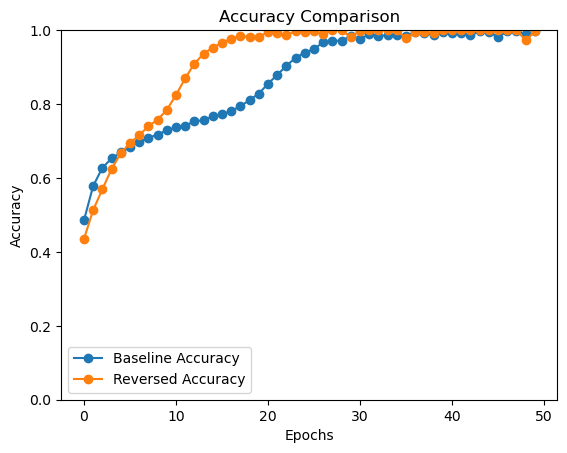

In [196]:
plt.plot(history.history["accuracy"],"-o")
plt.plot(history2.history["accuracy"],"-o")
plt.legend(["Baseline Accuracy","Reversed Accuracy"])
plt.title("Accuracy Comparison")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.plot();